In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm
from scipy.signal import find_peaks_cwt, find_peaks
from rascal.util import refine_peaks
from matplotlib.lines import Line2D

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_arctest_20251224"

/home/hbahk/miniconda3/envs/twodfdr/lib/python3.12/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdul = fits.open(TESTDIR / "flat_150_490_1sec 2025-12-24.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

In [4]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec 2025-12-24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     188   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


In [5]:
from astropy.table import Table

Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


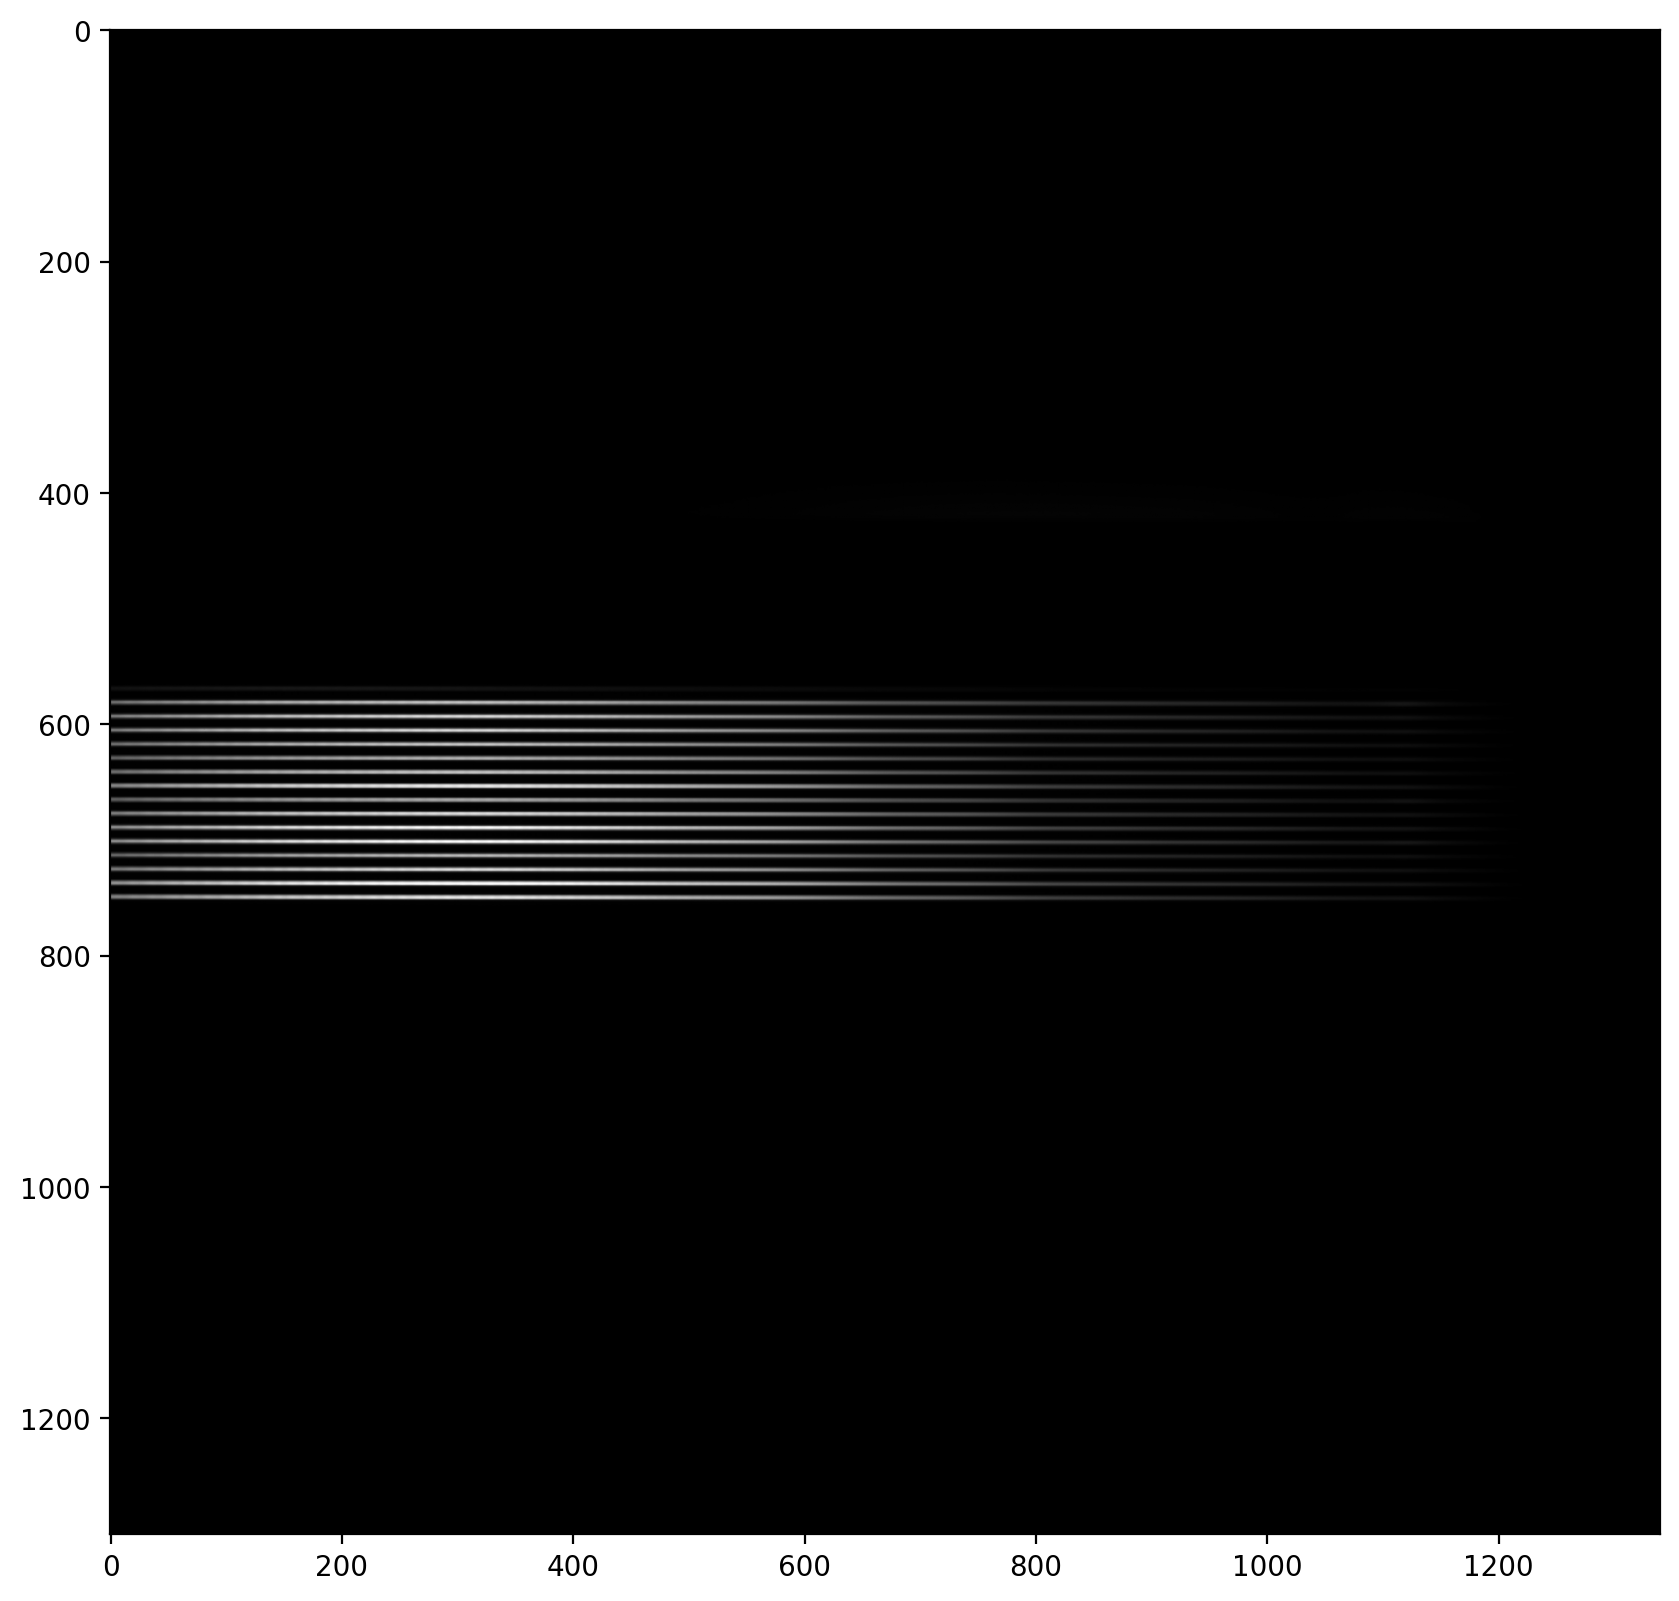

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [7]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (

INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.preproc.make_im:Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.01% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits


'/data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits'

In [8]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 6)

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)


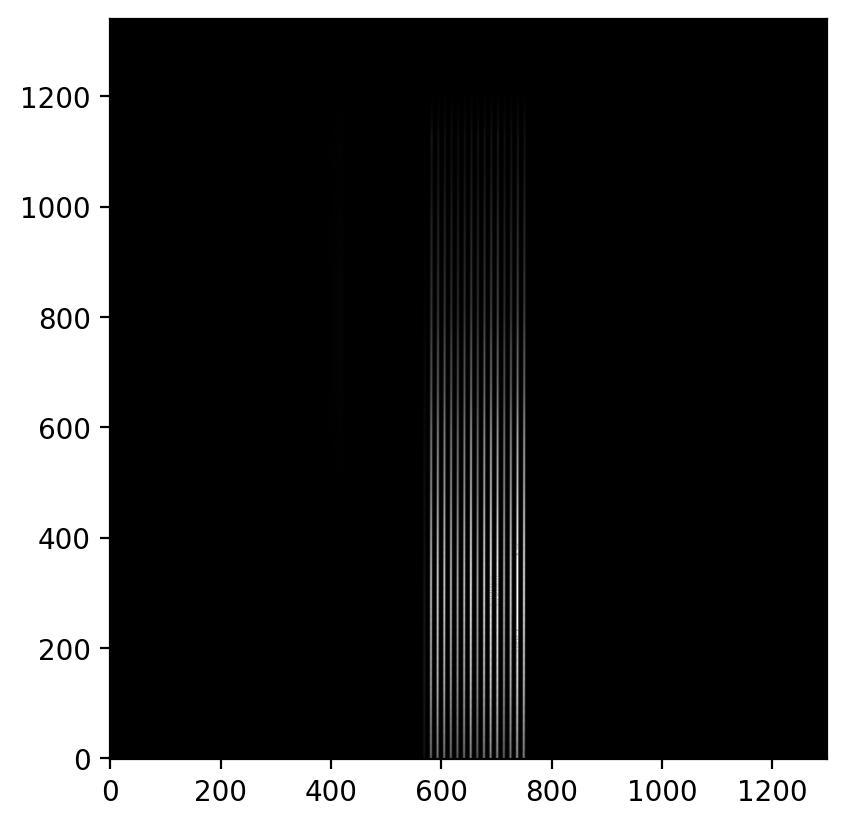

In [9]:
plt.imshow(img_data, cmap='gray', origin='lower')
plt.show()

In [10]:
im.get_instrument_code()

99

In [11]:
make_tlm(args)

INFO:kspecdr.tlm.make_tlm:Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.tlm.make_tlm:Instrument code: 99
INFO:kspecdr.tlm.make_tlm:Starting tramline map generation for non-2DF instrument
INFO:kspecdr.tlm.make_tlm:Fibres officially in use: 16
INFO:kspecdr.tlm.make_tlm:Fibres potentially able: 0
INFO:kspecdr.tlm.make_tlm:Fibres officially dead: 0
INFO:kspecdr.tlm.make_tlm:Max number of traces: 16
INFO:kspecdr.tlm.make_tlm:Sweeping image for signs of fibre traces...
INFO:kspecdr.tlm.make_tlm:Processing column 0/1340 (0.0%)
INFO:kspecdr.tlm.make_tlm:Processing column 50/1340 (3.7%)
INFO:kspecdr.tlm.make_tlm:Processing column 100/1340 (7.5%)
INFO:kspecdr.tlm.make_tlm:Processing column 150/1340 (11.2%)
INFO:kspecdr.tlm.make_tlm:Processing column 200/1340

In [12]:
fpath_tlm = new_fpath.parent / (new_fpath.stem + "_tlm.fits")

tlm = ImageFile(fpath_tlm.as_posix(), mode='READ')
tlm.open()
print(tlm.get_size())

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
(1340, 16)
(16, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 16)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 16)   float64   


In [13]:
img_data.shape

(1340, 1300)

In [14]:
tlm_data

array([[567.69401709, 567.69628484, 567.69855072, ..., 569.06654125,
        569.06632479, 569.06610647],
       [580.21245421, 580.21375443, 580.21505485, ..., 582.12532737,
        582.12688879, 582.1284504 ],
       [593.05860806, 593.05776264, 593.05692015, ..., 594.5454696 ,
        594.54854212, 594.55161758],
       ...,
       [724.94505495, 724.94492894, 724.94480488, ..., 726.52137631,
        726.52386227, 726.52635018],
       [736.88583639, 736.88612582, 736.88641661, ..., 738.47236074,
        738.47444591, 738.47653242],
       [748.7039072 , 748.70587418, 748.7078398 , ..., 750.13420336,
        750.1343746 , 750.13454451]], shape=(16, 1340), dtype='>f8')

(0.0, 300.0)

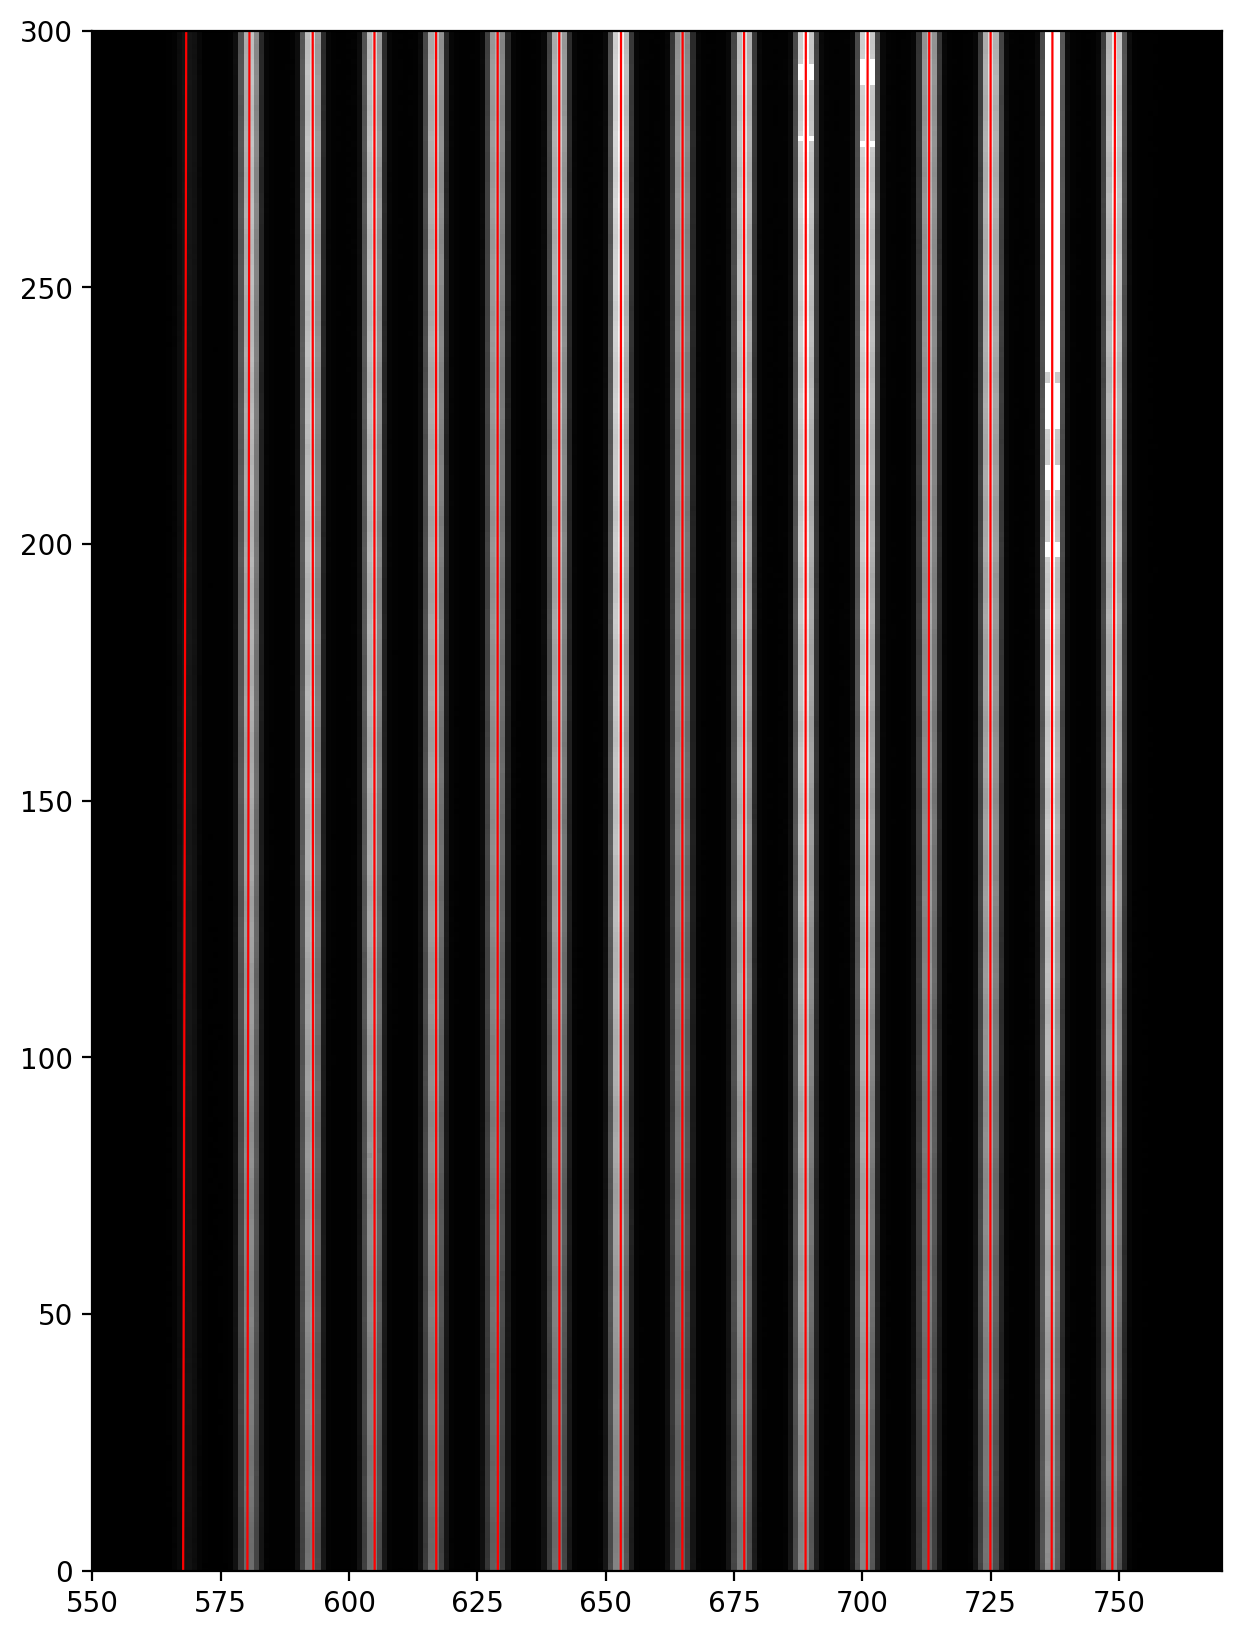

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower')
for tl in tlm_data:
    ax.plot(tl, np.arange(tl.shape[0]), c="r", lw=0.8)

ax.set_xlim(550, 770)
ax.set_ylim(0, 300)
# ax.set_ylim(1000, 1200)


In [16]:
from kspecdr.extract.make_ex import make_ex
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

args["EXTRAC_FILENAME"] = fpath_ex.as_posix()
args["TLMAP_FILENAME"] = fpath_tlm.as_posix()

make_ex(args)

hdul = fits.open(fpath_ex)

INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits (mode: READ)
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.extract.make_ex:Per

INFO:kspecdr.extract.make_ex:Written extracted file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits


Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     196   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


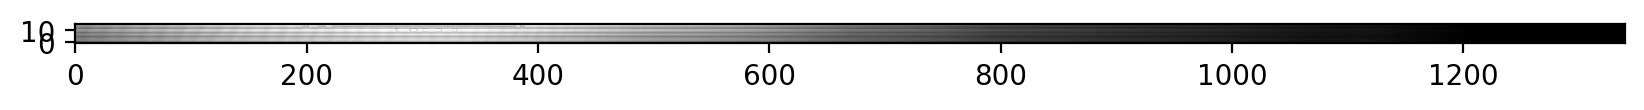

In [17]:
hdul = fits.open(fpath_ex)
hdul.info()

flat_ex = hdul[0].data

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(flat_ex, cmap='gray', origin='lower')
plt.show()

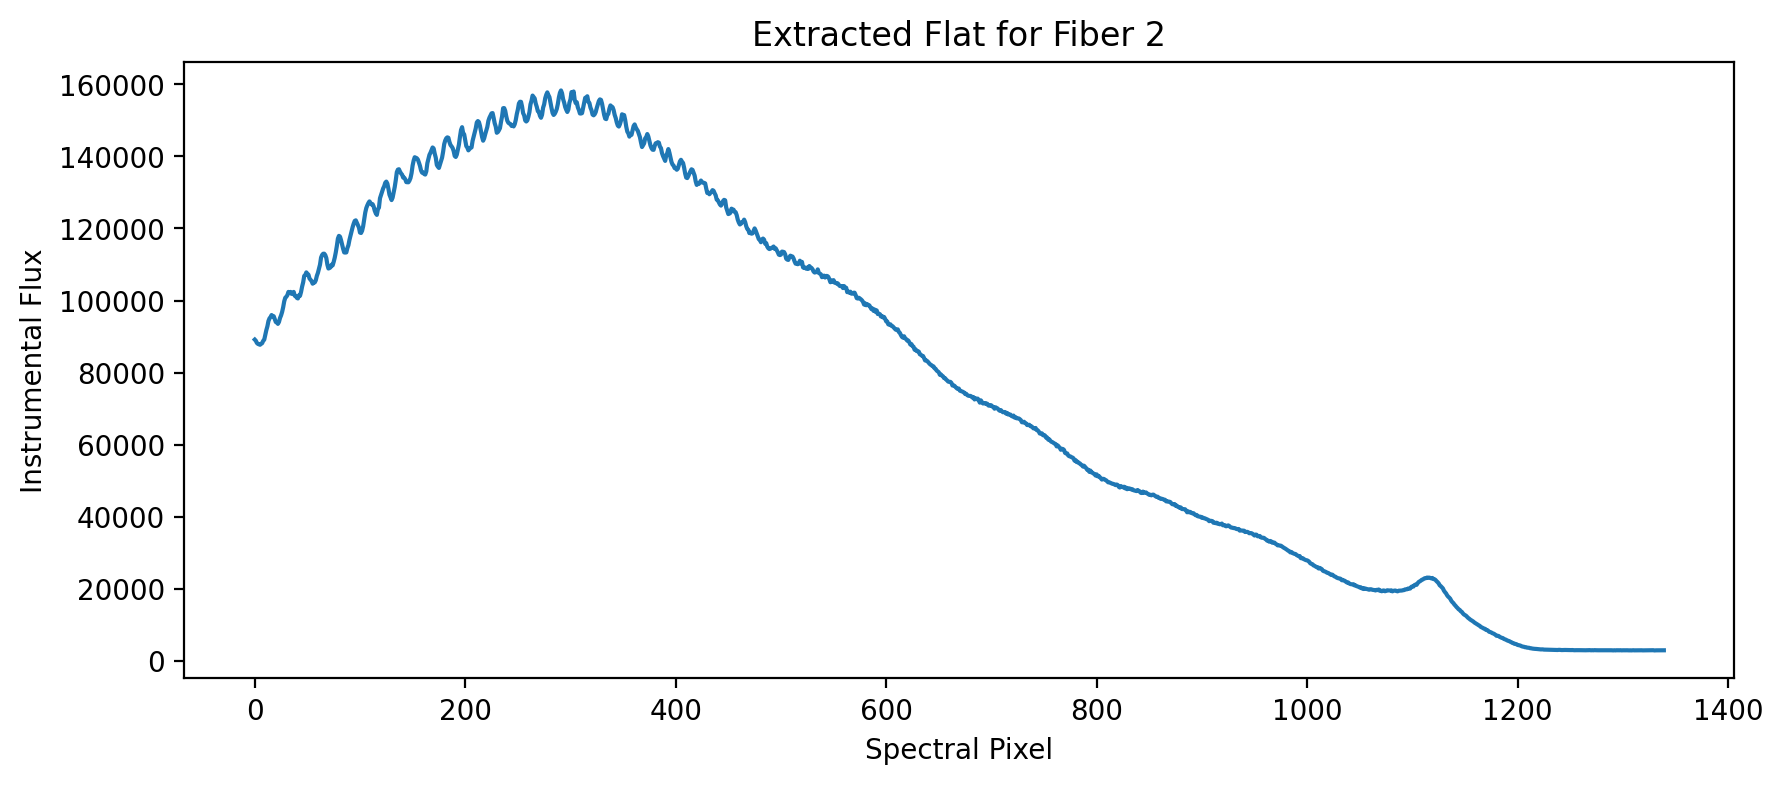

In [18]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(flat_ex[1])
ax.set_ylabel("Instrumental Flux")
ax.set_xlabel("Spectral Pixel")
ax.set_title("Extracted Flat for Fiber 2")
plt.show()


In [19]:
fpath = TESTDIR / r"Hg_paper_150_620_1sec 2025-12-24 12_09_50.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "flat_150_490_1sec_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
IN

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Hg_150_620_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     171   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


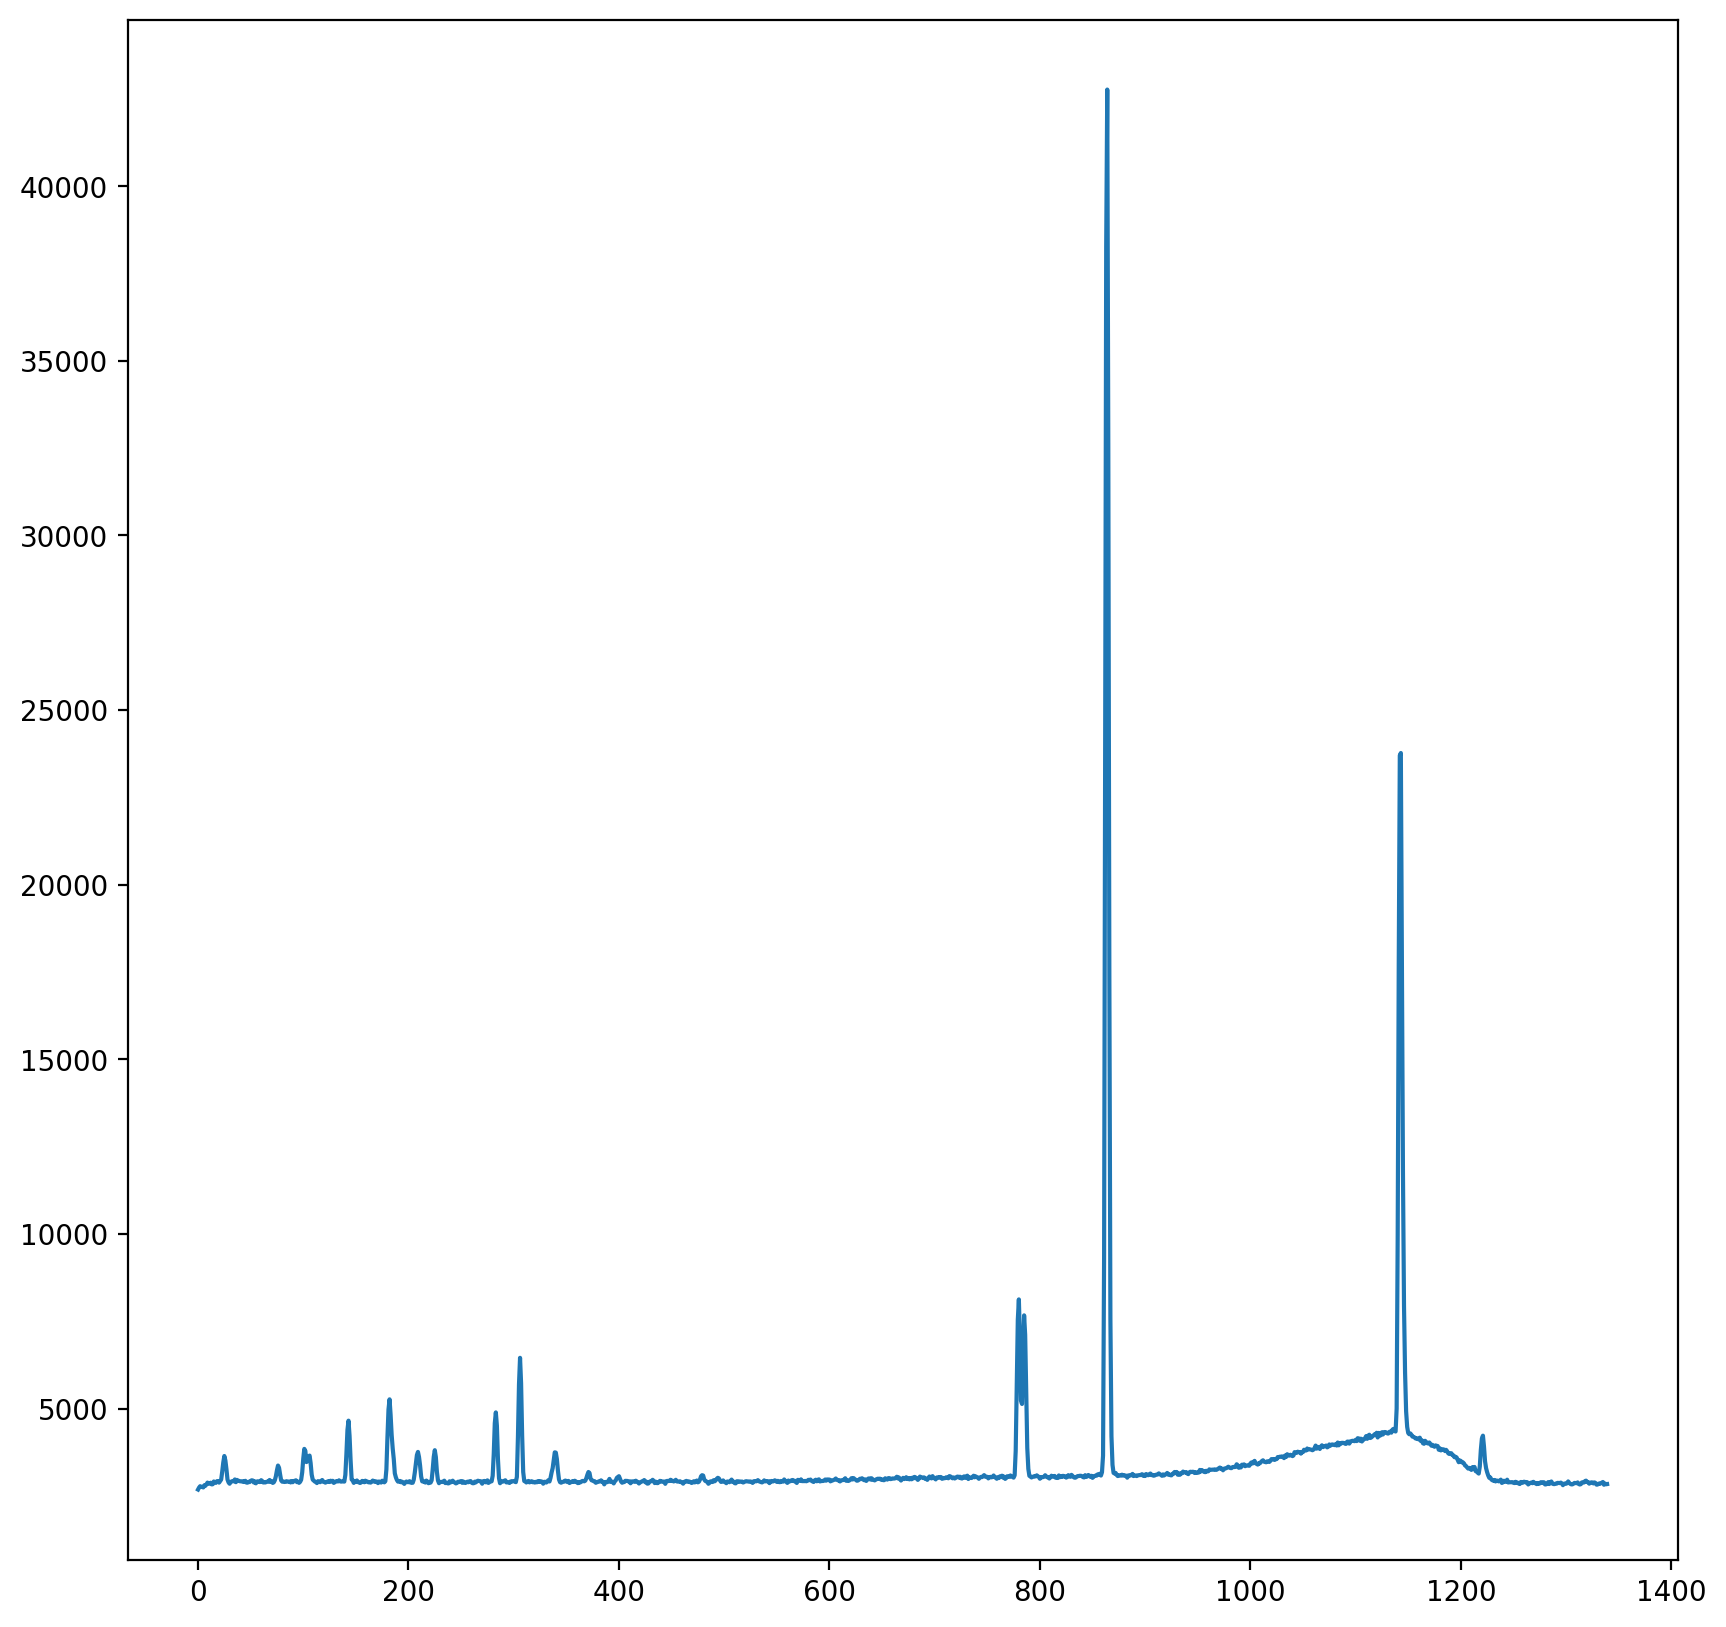

In [20]:
new_fpath = TESTDIR / "Hg_150_620_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
fibs = np.array([1, 2, 12, 13, 15, 16])
ifibs = fibs - 1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data[ifibs[0]])
plt.show()

hg_f1 = hdul[0].data[0][::-1]

In [21]:
fpath = TESTDIR / r"intellical_hg_150_620_f1 2025-12-24.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "intellical_hg_150_620_f1_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copy

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     205   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


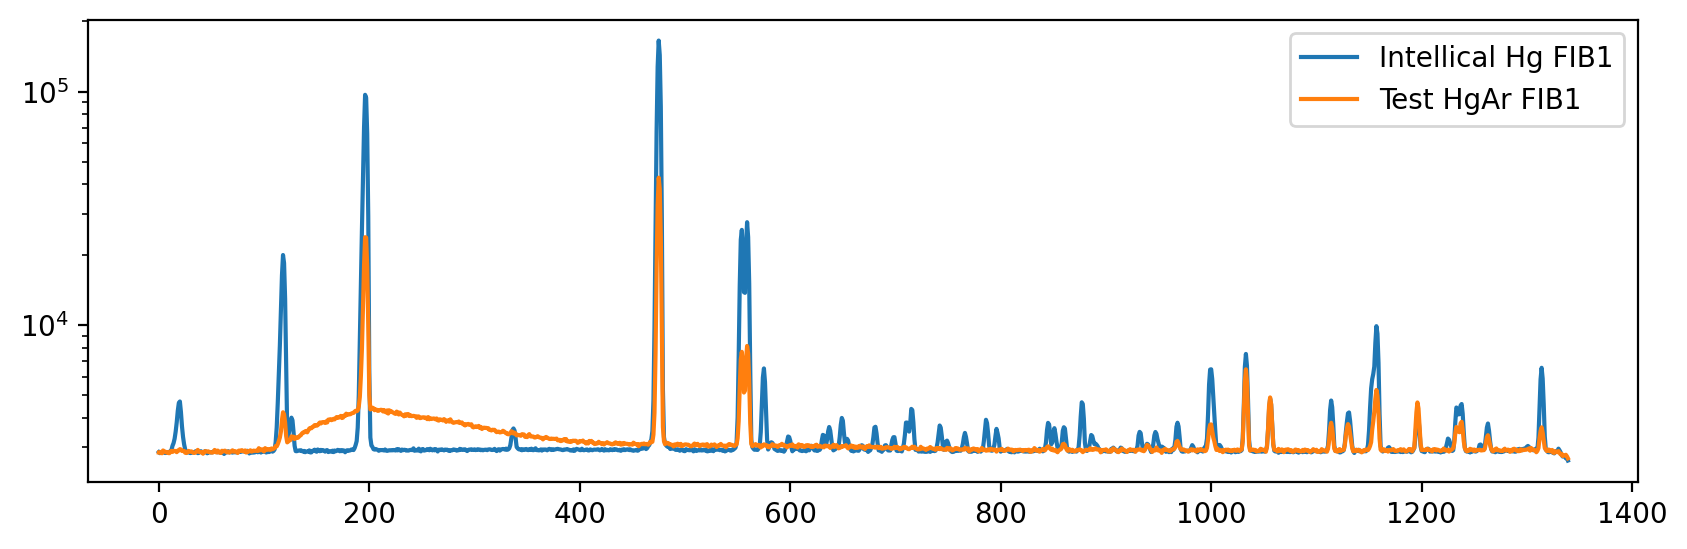

In [22]:
new_fpath = TESTDIR / "intellical_hg_150_620_f1_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

intellical_hg_f1 = hdul[0].data[0][::-1]

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(intellical_hg_f1, label="Intellical Hg FIB1")
ax.plot(hg_f1, label="Test HgAr FIB1")
ax.set_yscale("log")
ax.legend()
plt.show()

In [23]:
%matplotlib inline

In [24]:
newport_oriel = Table.read(RESOURCES / "spectral_atlas" / "newport-oriel.csv")
newport_hgar = newport_oriel[newport_oriel["Model No."] == 6035]
newport_ar = newport_oriel[newport_oriel["Model No."] == 6030]
newport_ne = newport_oriel[newport_oriel["Model No."] == 6032]

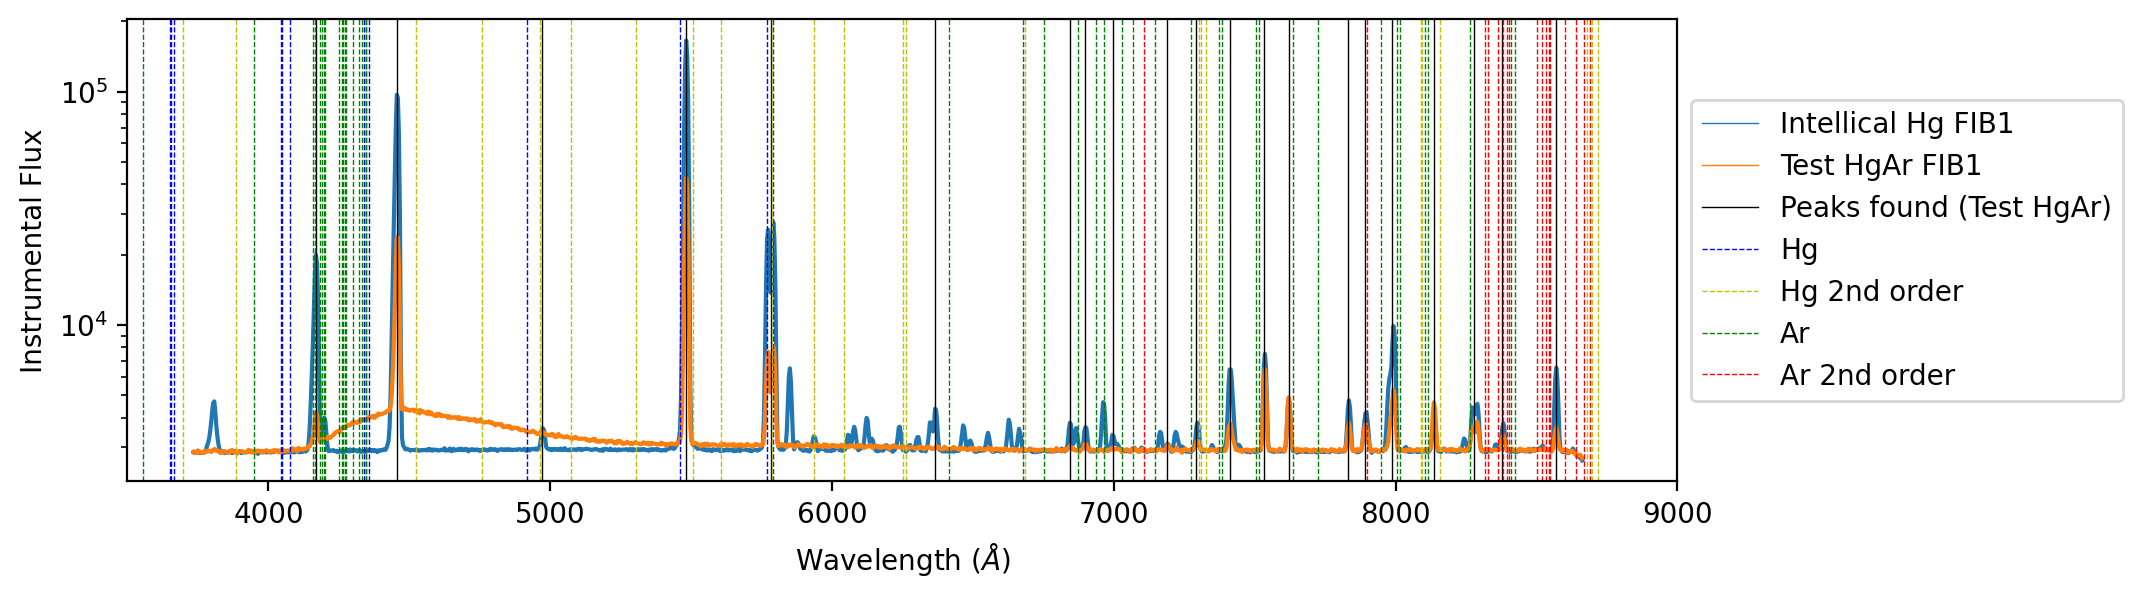

In [25]:
pixel = np.arange(len(intellical_hg_f1))
pix2lam = (pixel - len(pixel)/2)*3.68 + 6200

peaks = find_peaks_cwt(hg_f1, widths=5, min_snr=1)
# peaks, _ = find_peaks(intellical_hg_f1, height=3000, width=(0, 15), prominence=500)

peaks = refine_peaks(intellical_hg_f1, peaks, window_width=5)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(pix2lam, intellical_hg_f1, label="Intellical Hg FIB1")
ax.plot(pix2lam, hg_f1, label="Test HgAr FIB1")
for p in peaks:
    ax.axvline(pix2lam[int(p)], color="k", lw=0.5)
    
for line in newport_hgar["Wavelength (nm)"]:
    ax.axvline(line*10, color="b", lw=0.5, ls="--")
for line in newport_hgar["Wavelength (nm)"]:
    ax.axvline(line*20, color="y", lw=0.5, ls="--")
    
for line in newport_ar["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5, ls="--")
for line in newport_ar["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5, ls="--")
    
# patch to legend for axvlines to avoid duplicate legend entries
legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Intellical Hg FIB1"),
    Line2D([0], [0], color="tab:orange", lw=0.5, label="Test HgAr FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test HgAr)"),
    Line2D([0], [0], color="b", lw=0.5, ls="--", label="Hg"),
    Line2D([0], [0], color="y", lw=0.5, ls="--", label="Hg 2nd order"),
          Line2D([0], [0], color="g", lw=0.5, ls="--", label="Ar"),
          Line2D([0], [0], color="r", lw=0.5, ls="--", label="Ar 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yscale("log")
ax.set_xlim(3500, 9000)
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
plt.show()

In [32]:
import numpy as np
import plotly.graph_objects as go
from scipy.signal import find_peaks
from rascal.util import refine_peaks

def to_native_float(a):
    a = np.asarray(a)

    if a.dtype.byteorder not in ("=", "|"):
        a = a.byteswap().view(a.dtype.newbyteorder("="))

    return np.ascontiguousarray(a, dtype=np.float64)

# Convert arrays for Plotly (native endian)
x = to_native_float(pix2lam)
y1 = to_native_float(intellical_hg_f1)
y2 = to_native_float(hg_f1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, mode="lines", name="Intellical Hg FIB1"))
fig.add_trace(go.Scatter(x=x, y=y2, mode="lines", name="Test HgAr FIB1"))

# for p in peaks:
#     fig.add_vline(x=float(x[int(p)]), line_width=0.5, line_color="black")

# for line in newport_hgar["Wavelength (nm)"]:
#     fig.add_vline(x=float(line) * 10.0, line_width=0.5, line_dash="dash", line_color="red", name="Hg")

ymin = np.nanmin(y1[y1 > 0])
ymax = np.nanmax(y1)

for p in peaks:
    xp = float(x[int(p)])

    fig.add_trace(
        go.Scatter(
            x=[xp, xp],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="black", width=0.5, dash="dash"),
            hovertemplate=(
                "Peak<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", width=0.5),
            hovertemplate=(
                "Hg line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )
for line in newport_hgar["Wavelength (nm)"]:
    lam = float(line) * 10.0 * 3
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="yellow", width=0.5),
            hovertemplate=(
                "Hg 3rd line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

for line in newport_ar["Wavelength (nm)"]:
    lam = float(line) * 10.0
    fig.add_trace(
        go.Scatter(
            x=[lam, lam],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="green", width=0.5),
            hovertemplate=(
                "Ar line<br>"
                "λ = %{x:.2f}<br>"
                "<extra></extra>"
            ),
            showlegend=False
        )
    )

fig.update_layout(
    width=1000,
    height=300,
    yaxis_type="log",
    xaxis_range=[3500, 9000],
    margin=dict(l=60, r=20, t=40, b=40),
    legend=dict(orientation="h", y=1.02, x=1, xanchor="right", yanchor="bottom"),
)

fig.show()

In [ ]:
user_hg = [3650.20, 3654.80, 3663.30, 4044.40, 4046.60, 4077.80, 4339.20, 4347.50, 4358.40, 5460.70, 5769.60, 5790.70]
user_ar = [7272.90, 7372.10, 7384.00, 7503.90, 7514.60, 7635.1, 7948.2, 8006.20, 8014.80, 8103.70, 8115.30, 8264.5,]

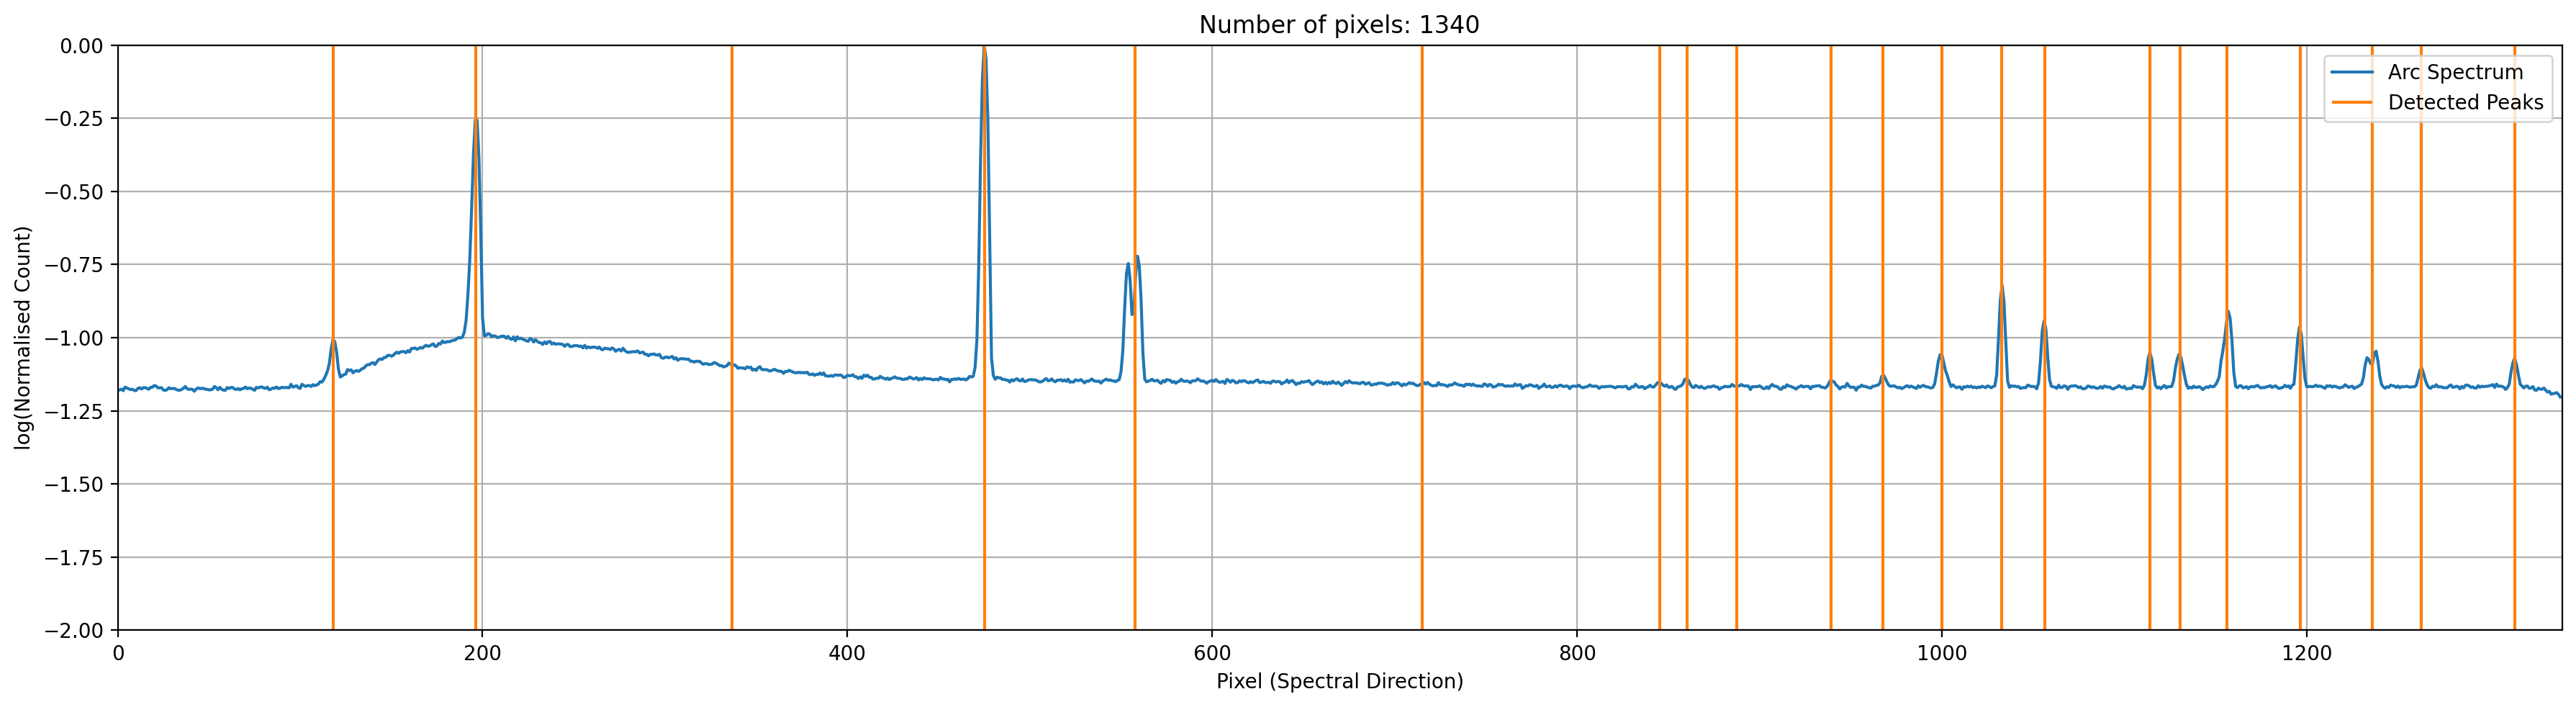

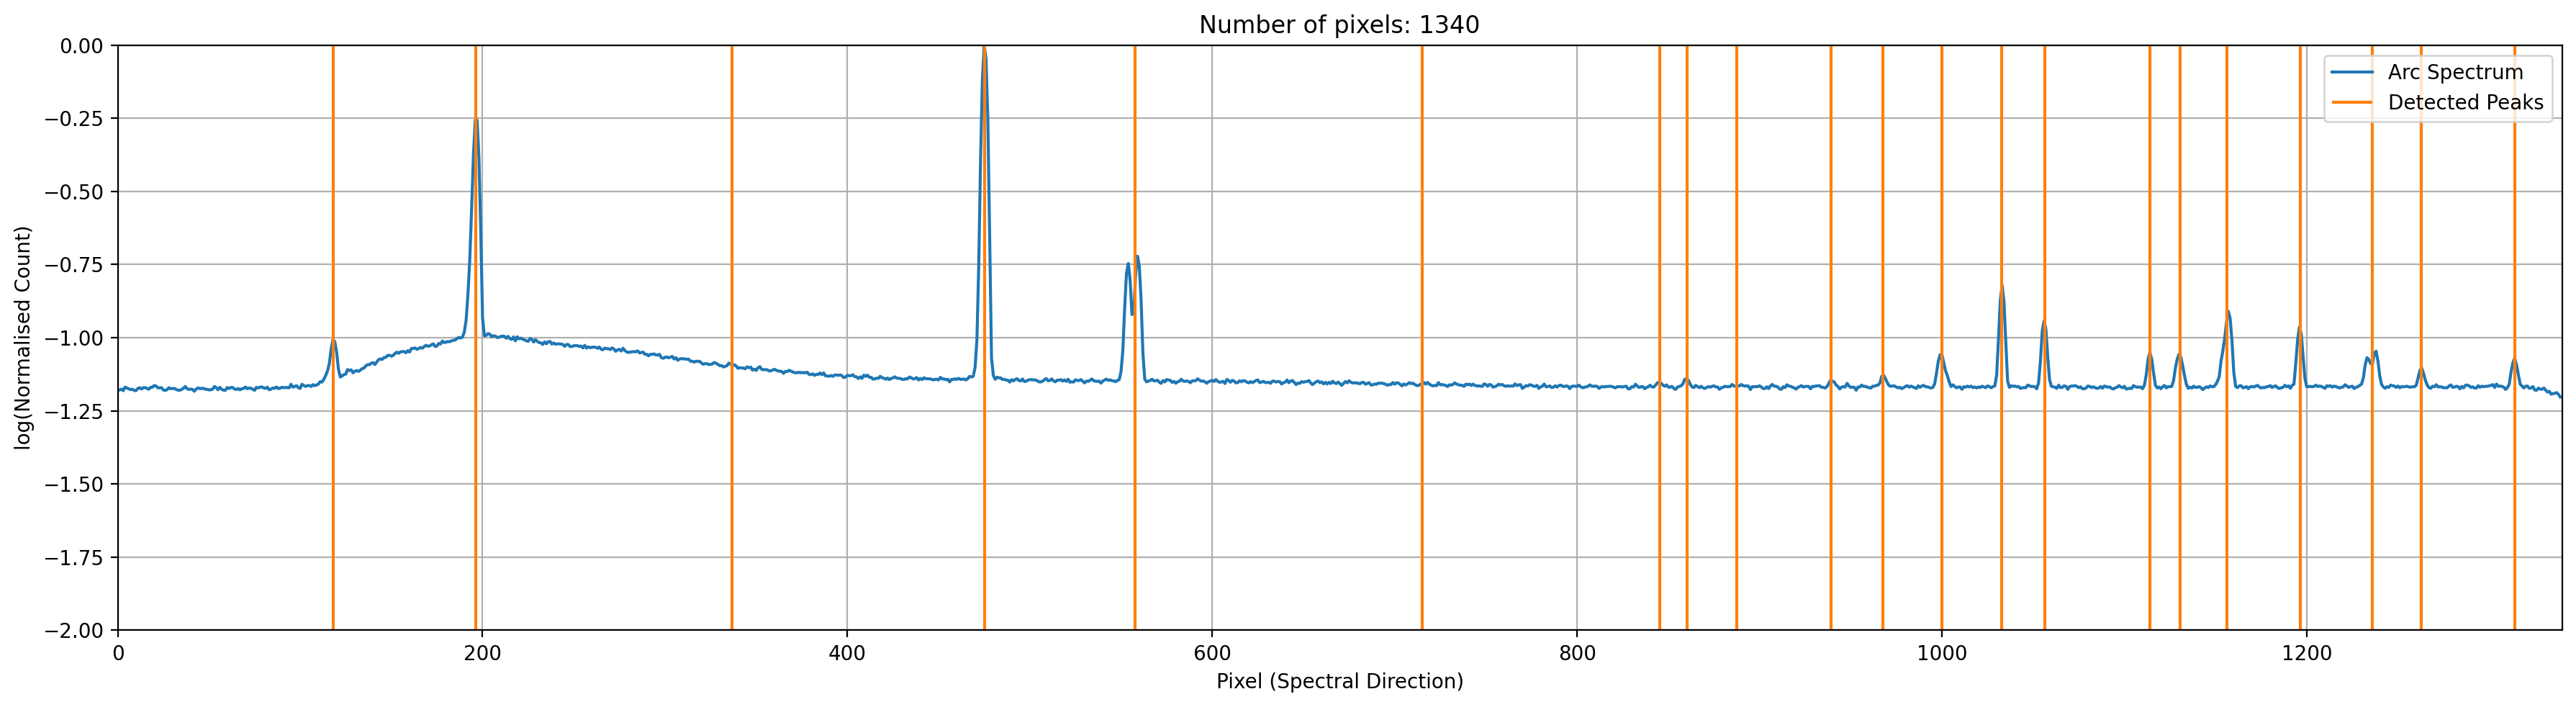

In [28]:
from rascal.calibrator import Calibrator

c = Calibrator(peaks, hg_f1)

c.set_hough_properties(
    num_slopes=5000,
    range_tolerance=500.0,
    xbins=200,
    ybins=200,
    min_wavelength=3500.0,
    max_wavelength=9500.0,
    linearity_tolerance=50.0,
)
c.set_ransac_properties(sample_size=5, top_n_candidate=5)

c.plot_arc(log_spectrum=True)

In [29]:
from rascal.atlas import Atlas

arclines_hg = newport_hgar["Wavelength (nm)"].data * 10
arclines_ar = newport_ar["Wavelength (nm)"].data * 10

arclines = np.concatenate([arclines_hg, arclines_ar])
# arclines = arclines_hg
elements = ["Hg"] * len(arclines_hg) + ["Ar"] * len(arclines_ar)
# elements = ["Hg"] * len(arclines_hg)

arclines = user_hg + user_ar
elements = ["Hg"] * len(user_hg) + ["Ar"] * len(user_ar)

atlas = Atlas(
    min_atlas_wavelength=3500.0,
    max_atlas_wavelength=9500.0,
    min_intensity=0.0,
)
atlas.add_user_atlas(
    elements=elements,
    wavelengths=arclines,
)

c.set_atlas(atlas)

c.do_hough_transform()

fit_result = c.fit(max_tries=500, fit_deg=2)
(
    fit_coeff,
    matched_peaks,
    matched_atlas,
    rms,
    residual,
    peak_utilisation,
    atlas_utilisation,
) = fit_result

  0%|          | 0/500 [00:00<?, ?it/s]

[Wed, 07 Jan 2026 10:06:19] WARNING [calibrator.py:1583] Invalid fit
[Wed, 07 Jan 2026 10:06:19] WARNING [calibrator.py:1586] RMS too large 1e+50 > 5.0


AssertionError: Couldn't fit with 168 pair(s) / 21 peaks / 8 lines.

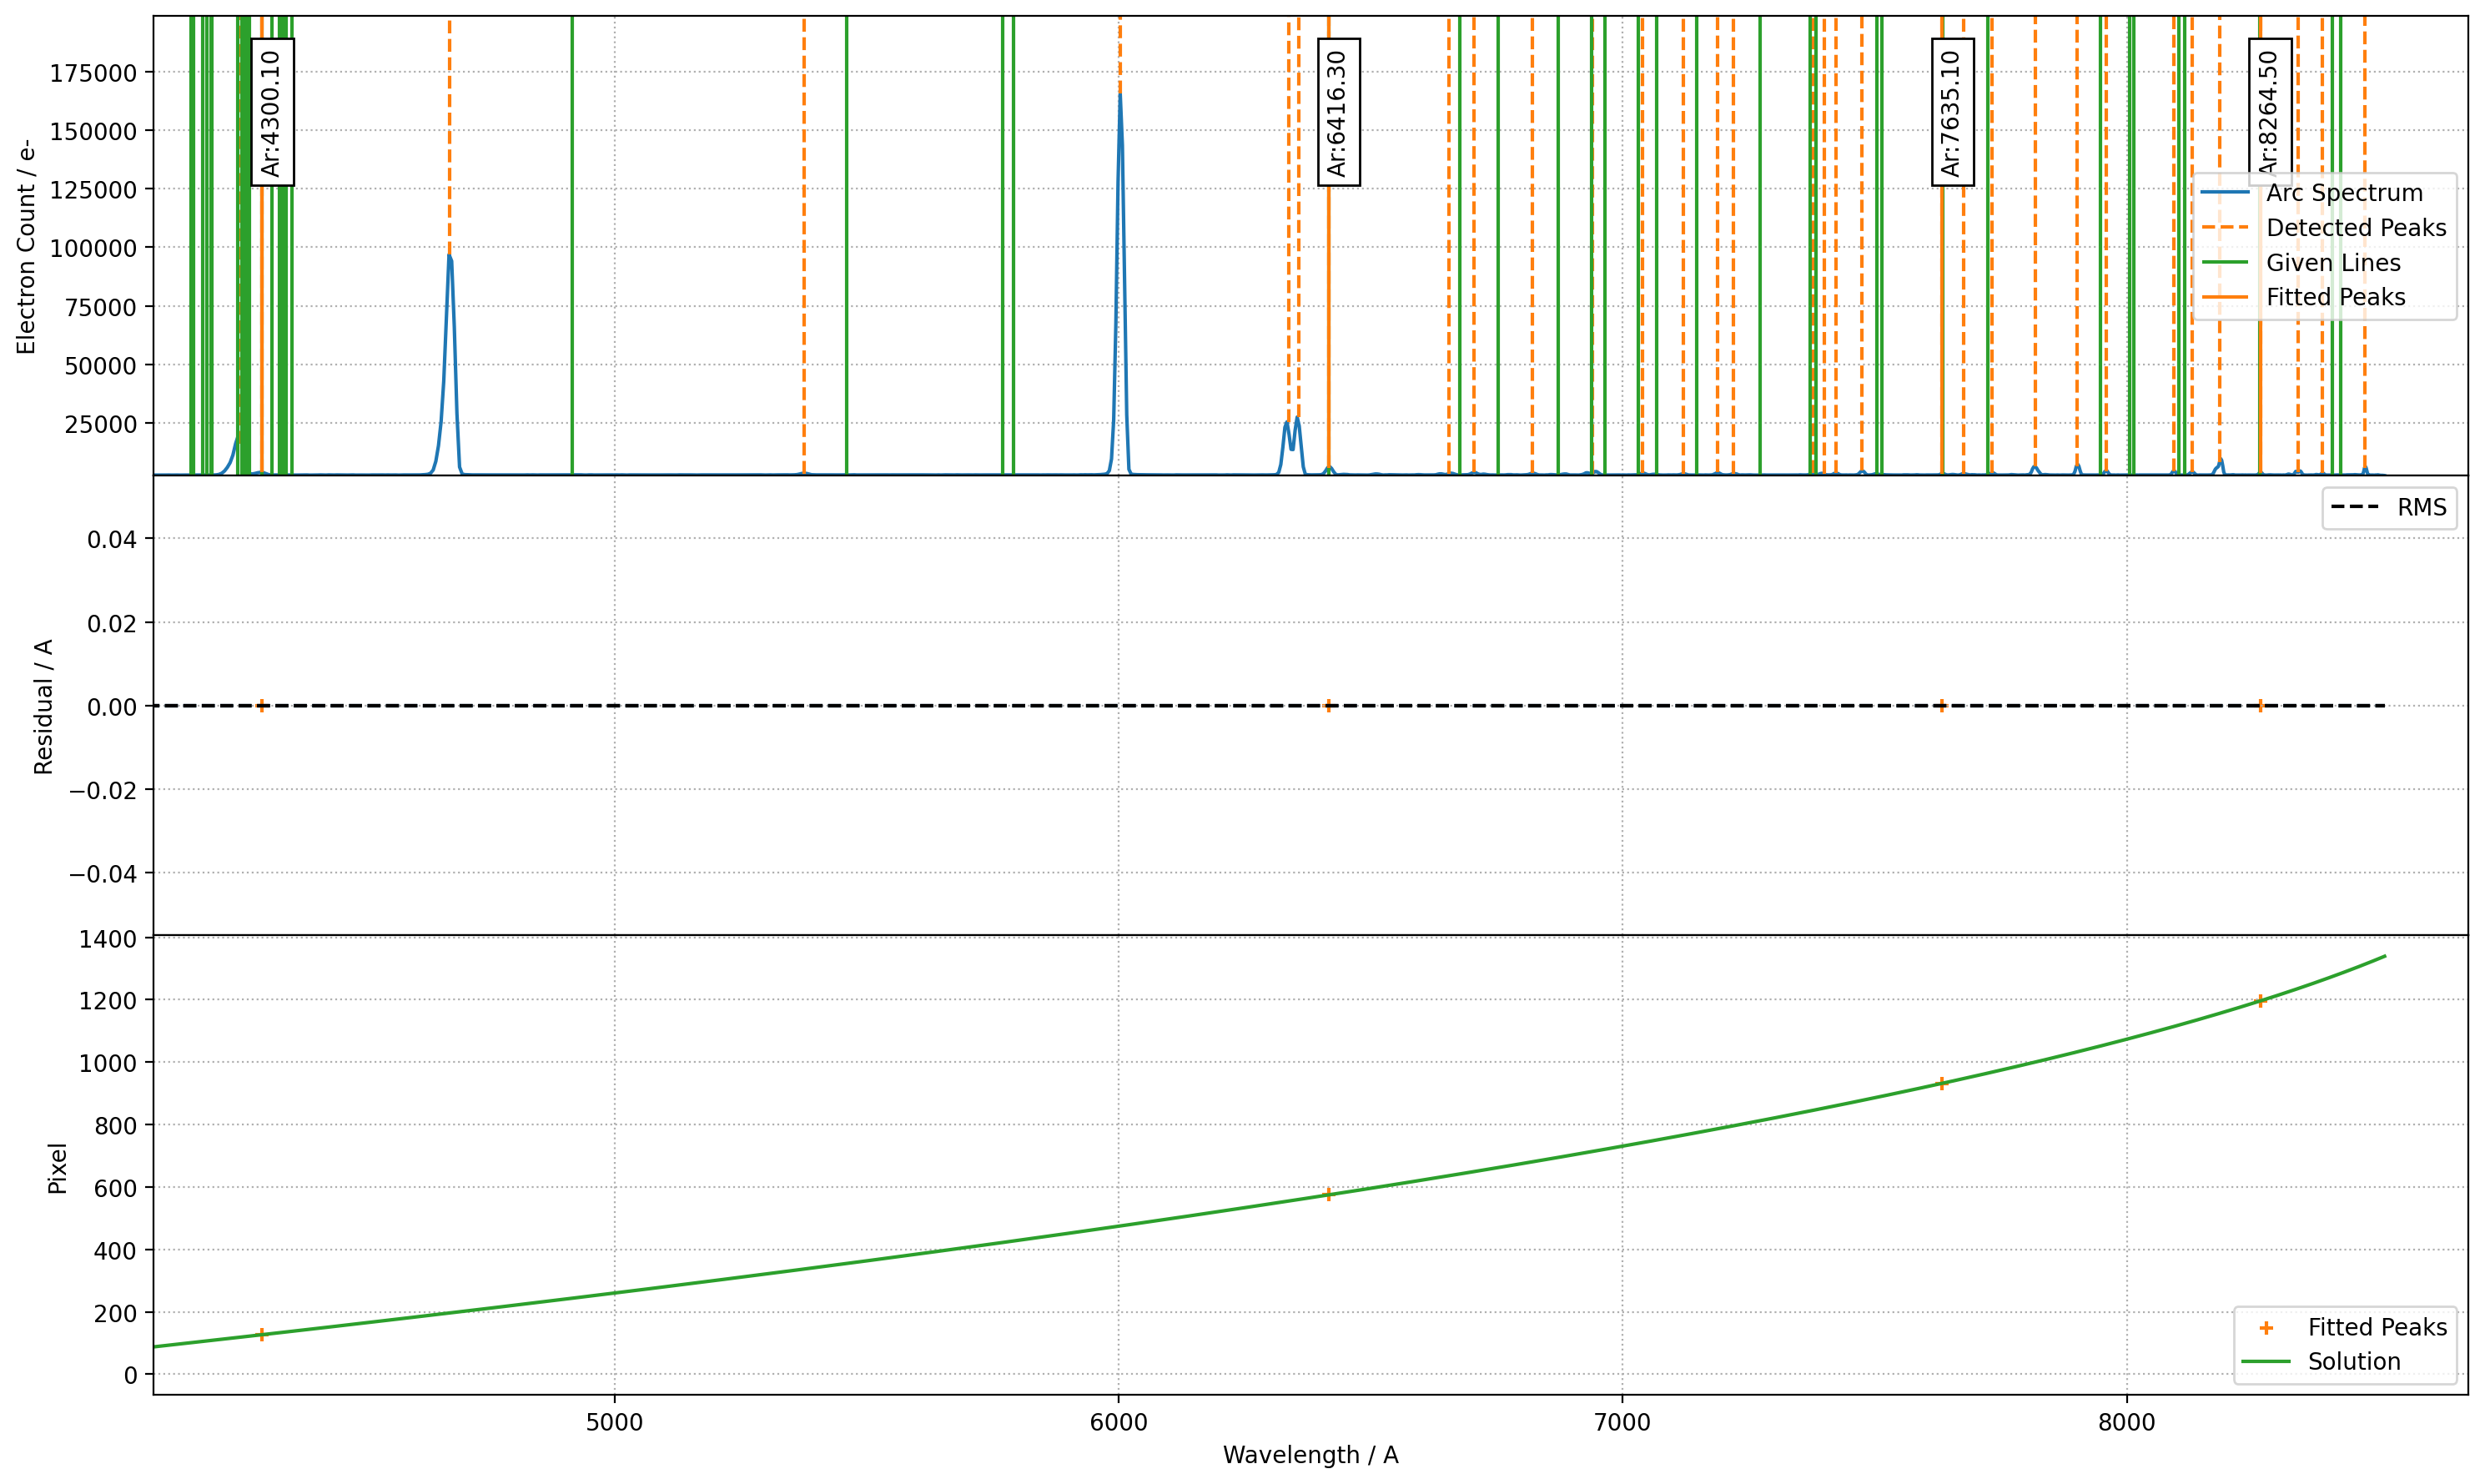

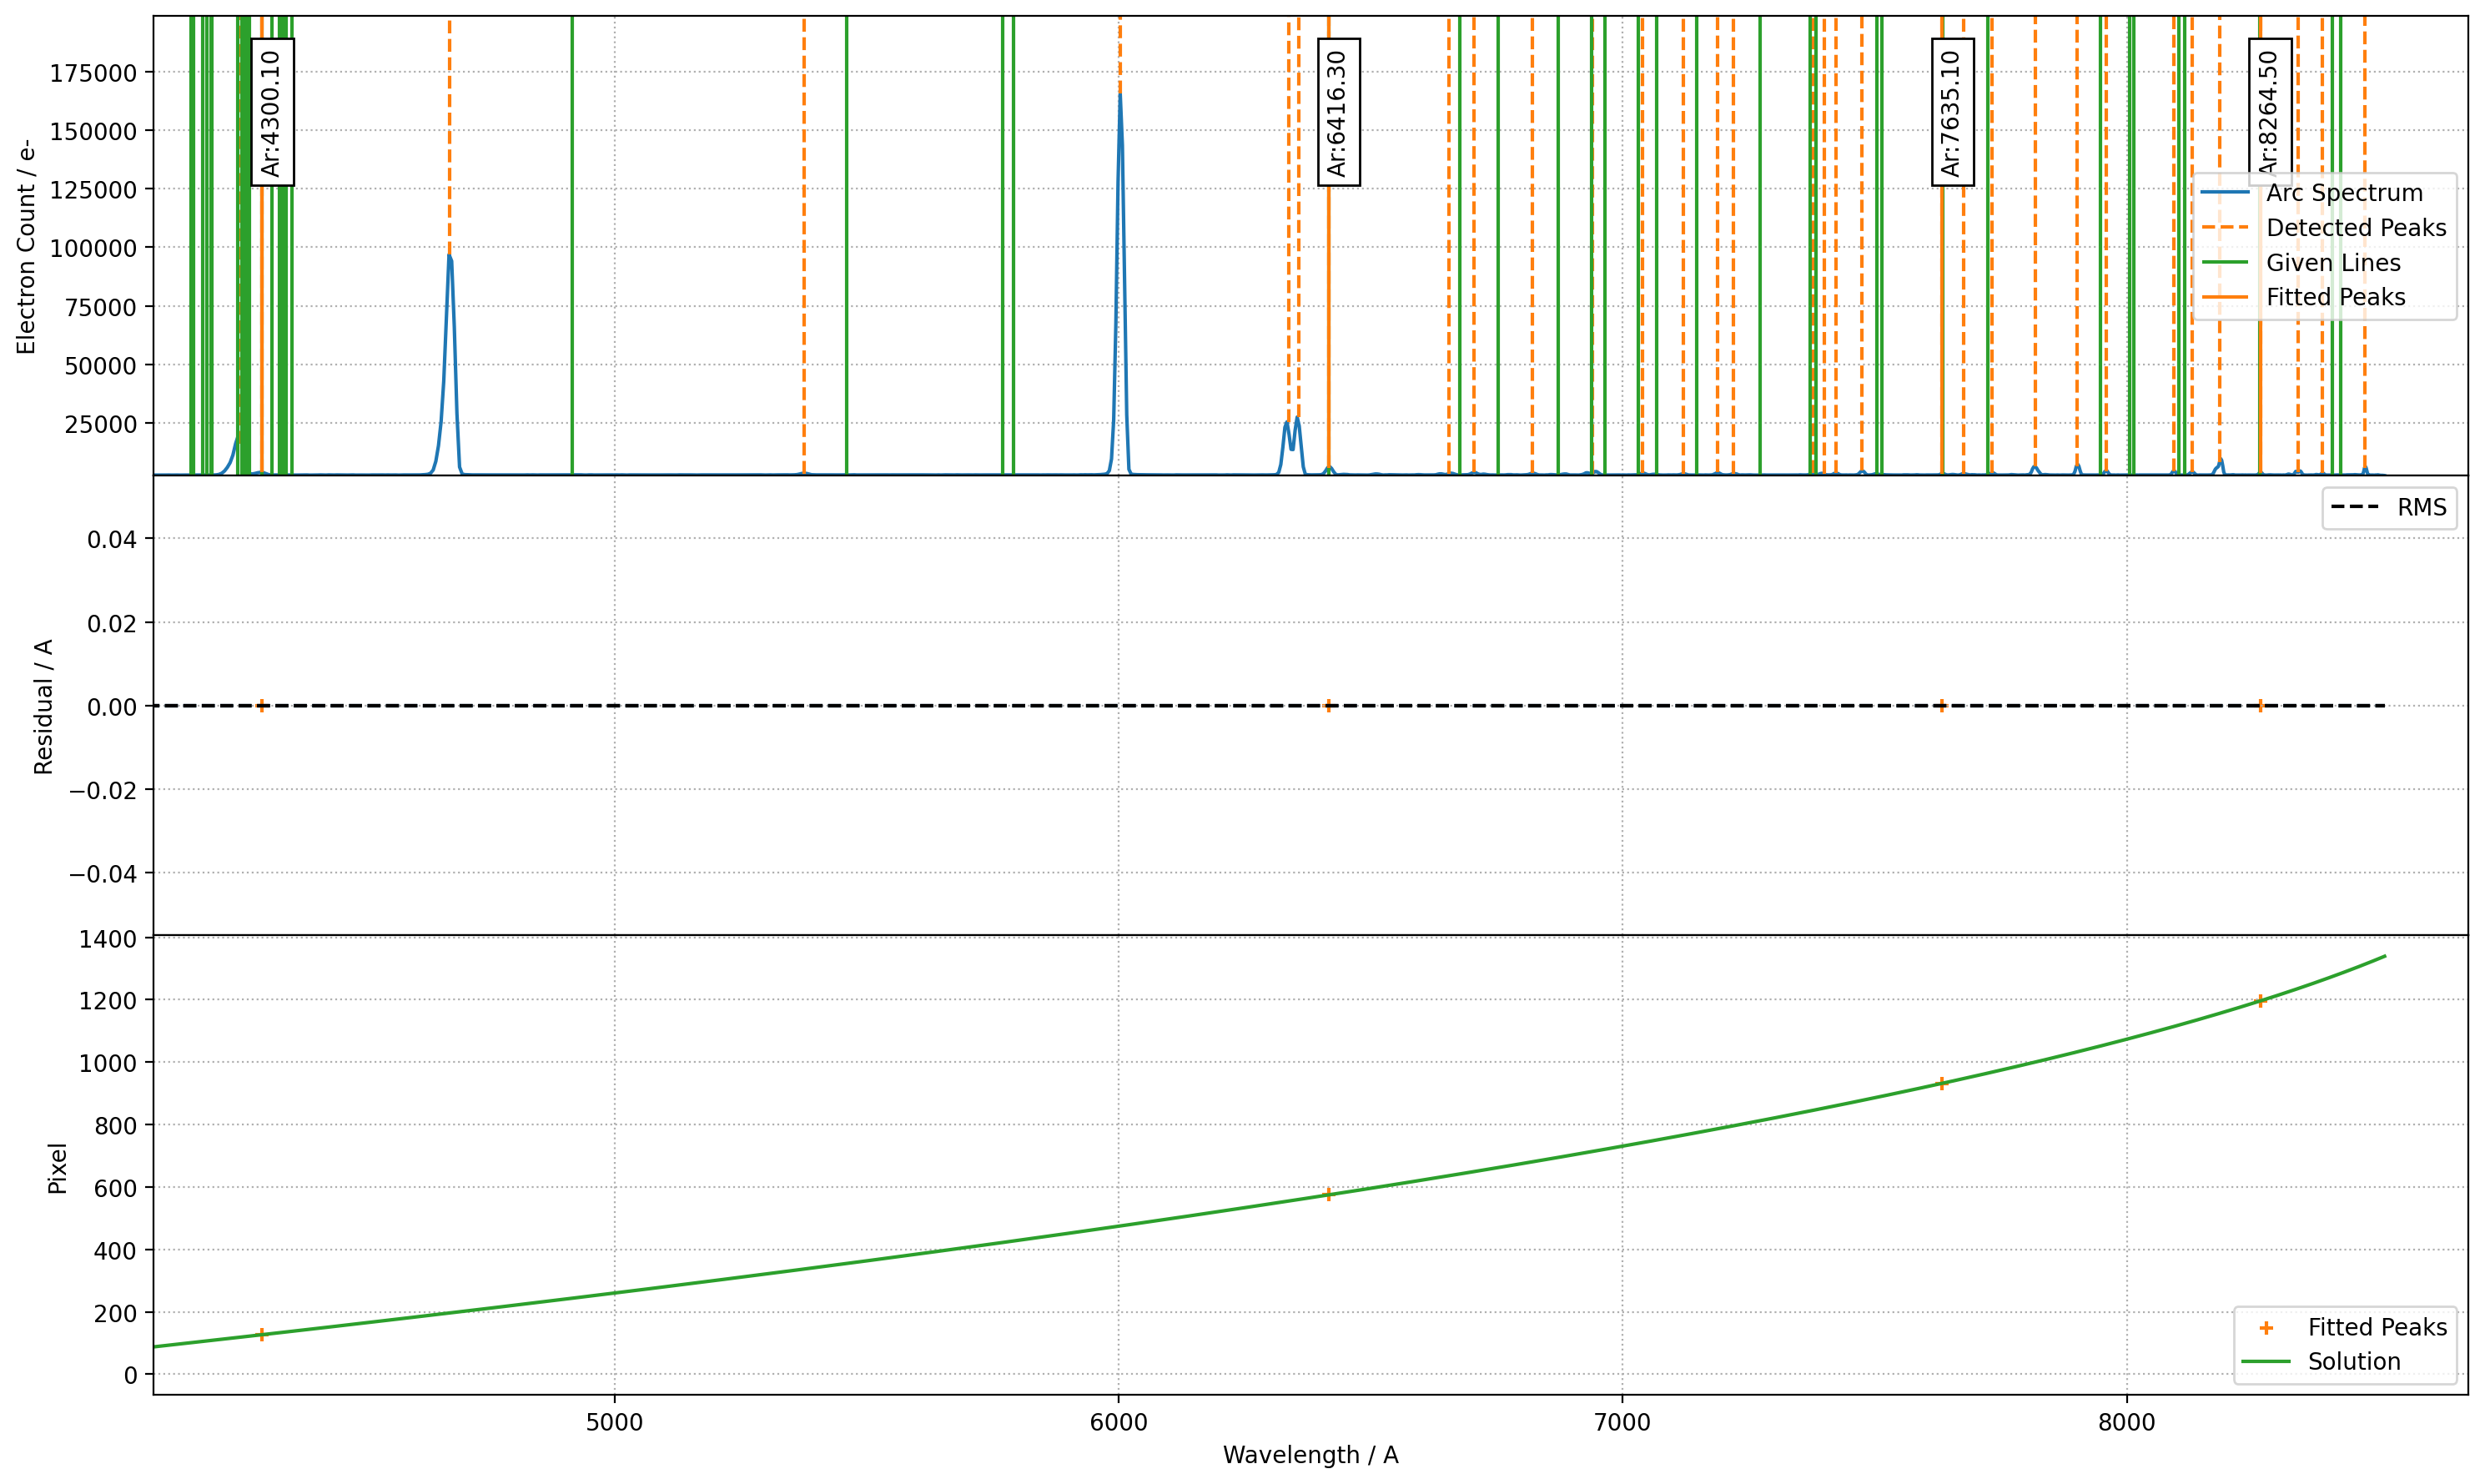

In [ ]:
c.plot_fit(fit_result[0])

In [ ]:
fpath = TESTDIR / r"Ne_150_620_0.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "Ne_150_620_0_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opene

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits (mode: UPDATE)
INFO:kspecdr.preproc.make_im:0.00% of pixels were saturated
INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits
INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_im.fits (mode: READ)
INFO:k

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Ne_150_620_0_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     195   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


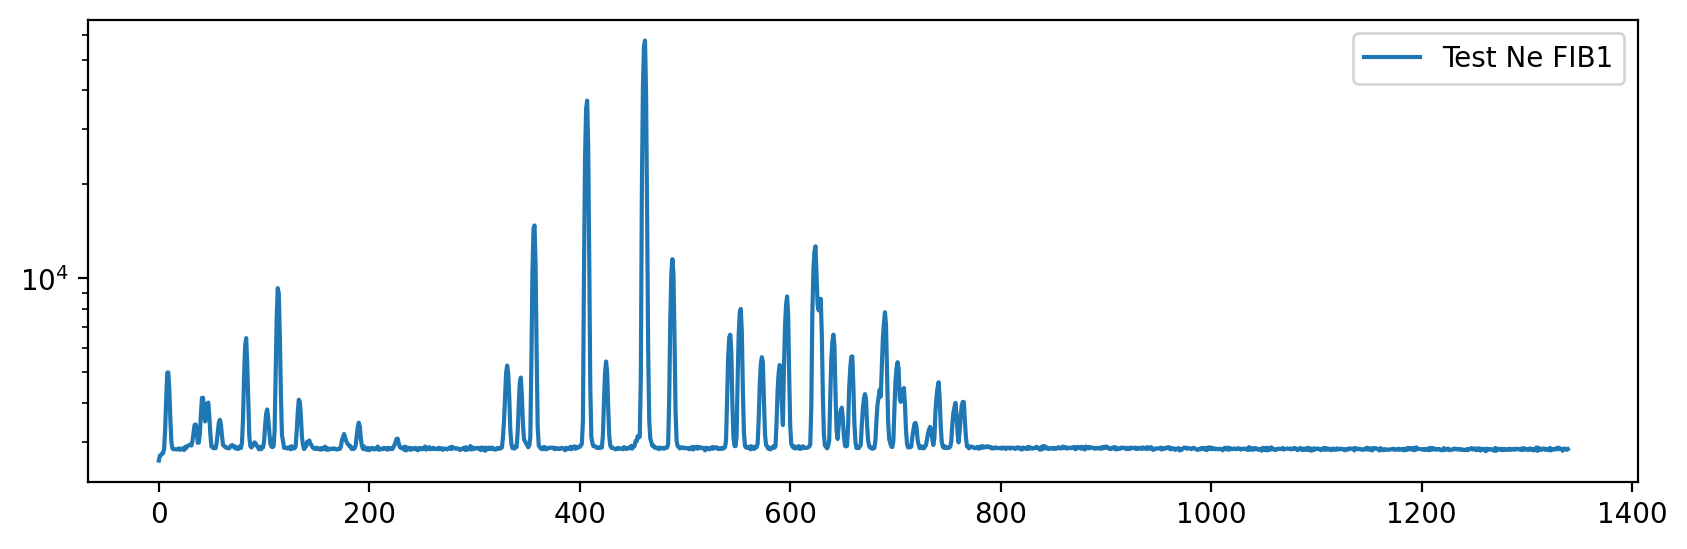

In [ ]:
new_fpath = TESTDIR / "Ne_150_620_0_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]


fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data[0], label="Test Ne FIB1")
ax.set_yscale("log")
ax.legend()
plt.show()

near_f1 = hdul[0].data[0][::-1]

In [ ]:
im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
print(im.read_header_keyword("LAMBDAC"))
print(im.read_header_keyword("DISPERS"))
print(im.read_header_keyword("GRATLPMM"))
print(im.read_header_keyword("GRATID"))
print(im.read_header_keyword("SPECTID"))
print(im.read_header_keyword("OBSTYPE"))


INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_hg_150_620_f1_converted_im.fits (mode: READ)
('6200.0', 'Central wavelength in Angstrom')
('3.68', 'Central dispersion (Angstrom/pixel)')
('150', 'Grating Lines per mm')
('150', 'Grating ID')
('UNKNOWN', 'Spectrograph ID')
('OBJECT', 'Observation type')


In [ ]:
fpath = TESTDIR / r"intellical_near_150_620_f1 2025-12-24.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "intellical_near_150_620_f1_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.ma

INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits
INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_im.fits (mode: READ)
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
INFO:k

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/intellical_near_150_620_f1_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     205   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


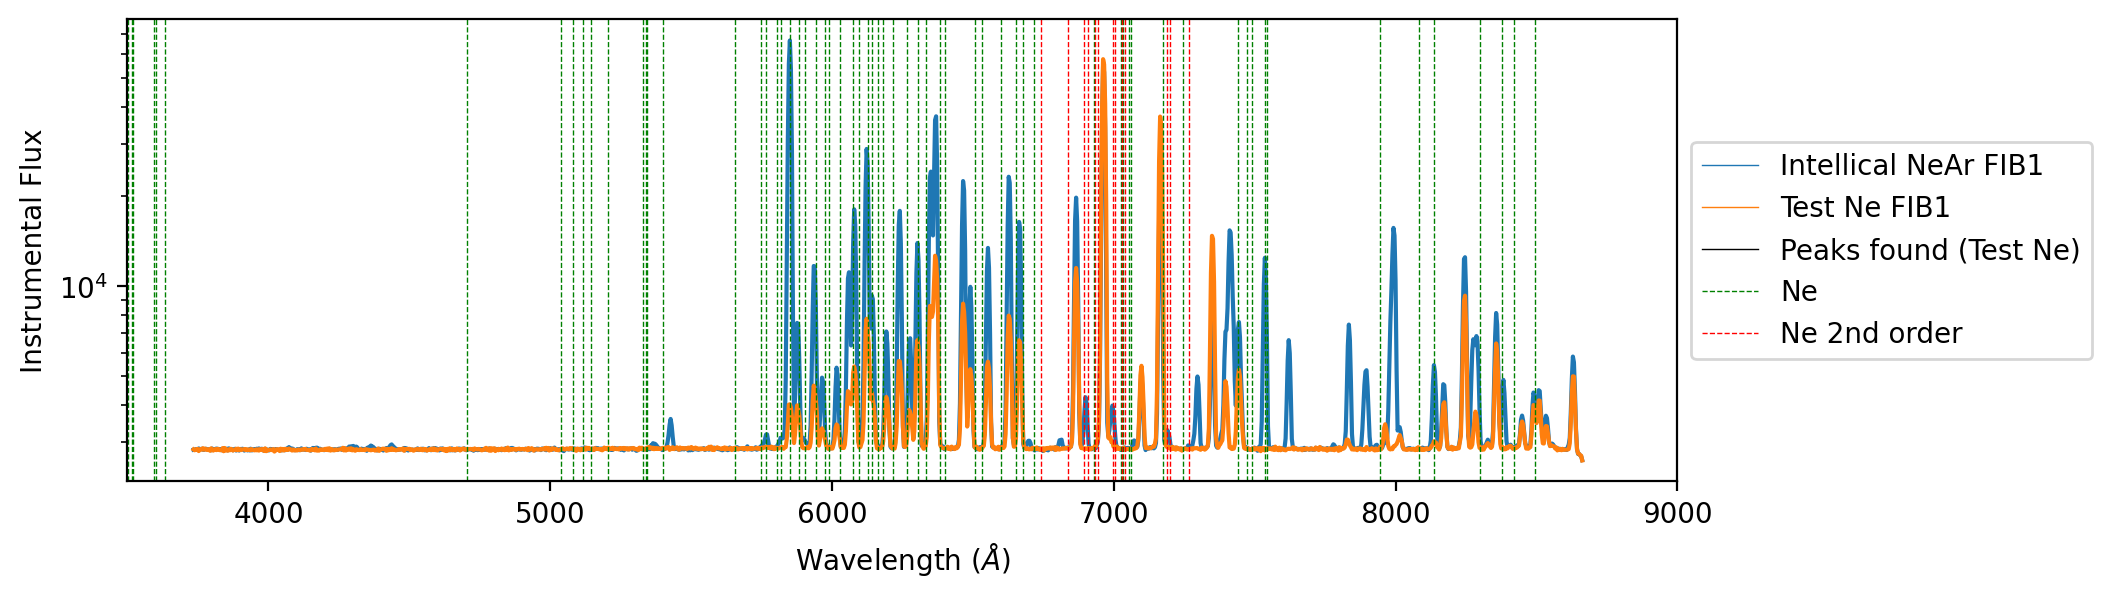

In [ ]:
new_fpath = TESTDIR / "intellical_near_150_620_f1_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

intellical_near_f1 = hdul[0].data[0][::-1]

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(pix2lam, intellical_near_f1, label="Intellical NeAr FIB1")
ax.plot(pix2lam, near_f1, label="Test Ne FIB1")

for line in newport_ne["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5, ls="--")
    
for line in newport_ne["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5, ls="--")
# for line in newport_ar["Wavelength (nm)"]:
#     ax.axvline(line*10, color="r", lw=0.5, ls="--")

legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Intellical NeAr FIB1"),
    Line2D([0], [0], color="tab:orange", lw=0.5, label="Test Ne FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test Ne)"),
    Line2D([0], [0], color="g", lw=0.5, ls="--", label="Ne"),
    Line2D([0], [0], color="r", lw=0.5, ls="--", label="Ne 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(3500, 9000)

ax.set_yscale("log")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
# ax.legend()
plt.show()

In [ ]:
fpath = TESTDIR / r"Kr_150_620_0.fits"
hdul = fits.open(fpath)
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "Kr_150_620_0_converted.fits"
hdul.writeto(new_fpath, overwrite=True)

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        verbose=False)

fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

INFO:kspecdr.preproc.make_im:Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
INFO:kspecdr.preproc.make_im:Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_im.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted.fits (mode: READ)
INFO:kspecdr.preproc.make_im:Creating variance HDU for raw file
INFO:kspecdr.preproc.make_im:Copying fiber table from source file
INFO:kspecdr.io.image:Opene

INFO:kspecdr.preproc.make_im:No bias subtraction performed
INFO:kspecdr.preproc.make_im:Variance HDU created and initialized
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_im.fits
INFO:kspecdr.extract.make_ex:Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_im.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits
INFO:kspecdr.extract.make_ex:Extraction Method: TRAM
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_im.fits (mode: READ)
INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/flat_150_490_1sec_converted_tlm.fits (mode: READ)
INFO:kspecdr.io.image:Closed file: /data1/hbahk/kspec/kspecdr/

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_arctest_20251224/Kr_150_620_0_converted_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     195   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   


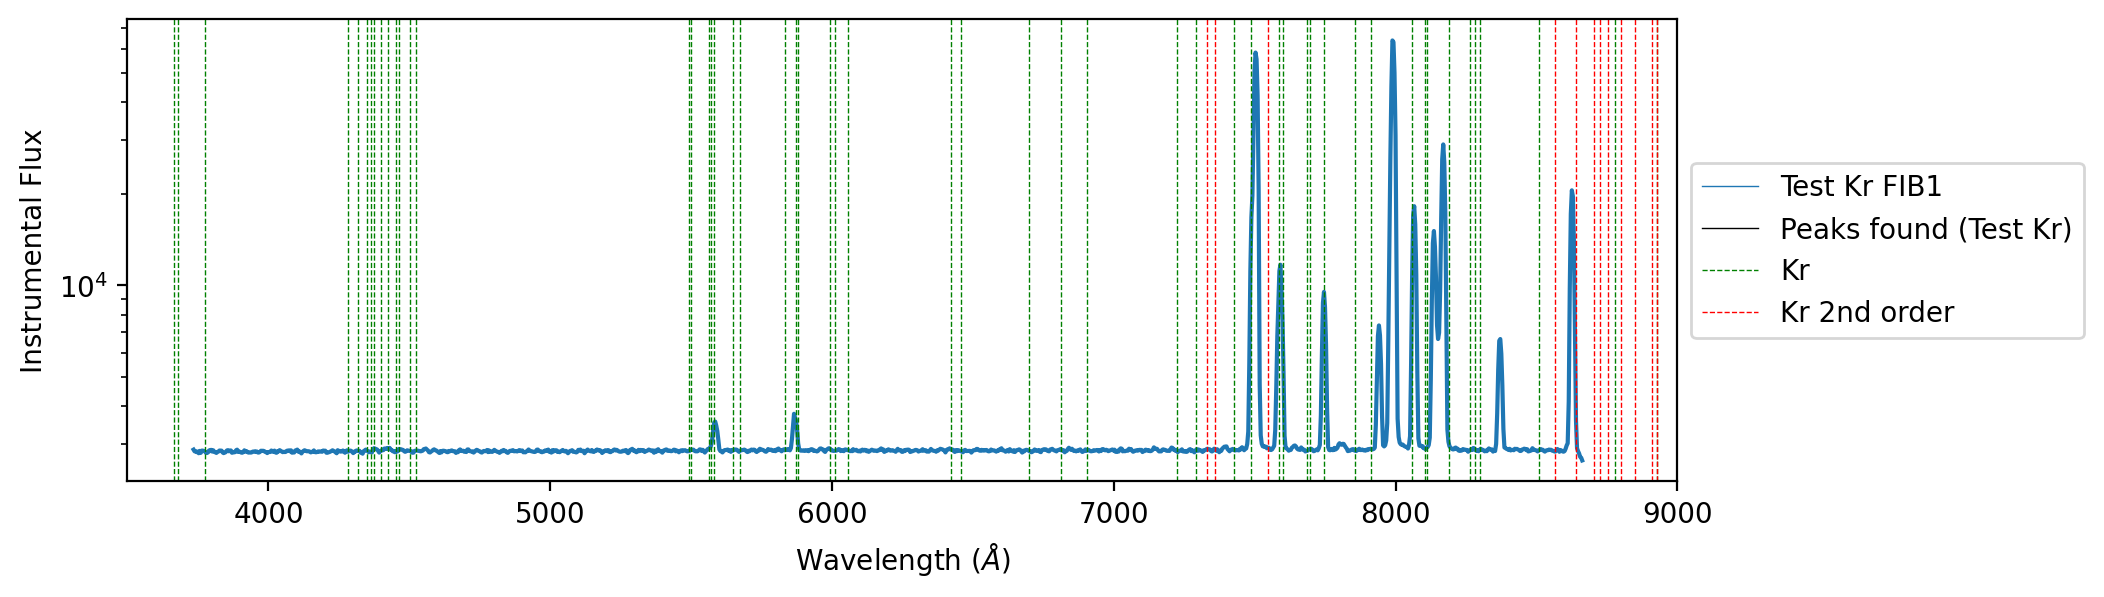

In [ ]:
new_fpath = TESTDIR / "Kr_150_620_0_converted.fits"
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
fpath_ex = new_fpath.parent / (new_fpath.stem + "_ex.fits")

hdul = fits.open(fpath_ex)
hdul.info()
tlm_hdul = fits.open(fpath_tlm)
wavela = tlm_hdul[1].data[0]

kr_f1 = hdul[0].data[0][::-1]

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
pixel = np.arange(len(kr_f1))
pix2lam = (pixel - len(pixel)/2)*3.68 + 6200
ax.plot(pix2lam, kr_f1, label="Test Kr FIB1")

newport_kr = newport_oriel[newport_oriel["Model No."] == 6031]

for line in newport_kr["Wavelength (nm)"]:
    ax.axvline(line*10, color="g", lw=0.5, ls="--")
    
for line in newport_kr["Wavelength (nm)"]:
    ax.axvline(line*20, color="r", lw=0.5, ls="--")
# for line in newport_ar["Wavelength (nm)"]:
#     ax.axvline(line*10, color="r", lw=0.5, ls="--")

legend_lines = [
    Line2D([0], [0], color="tab:blue", lw=0.5, label="Test Kr FIB1"),
    Line2D([0], [0], color="k", lw=0.5, label="Peaks found (Test Kr)"),
    Line2D([0], [0], color="g", lw=0.5, ls="--", label="Kr"),
    Line2D([0], [0], color="r", lw=0.5, ls="--", label="Kr 2nd order")]
ax.legend(handles=legend_lines, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(3500, 9000)

ax.set_yscale("log")
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Instrumental Flux")
# ax.legend()
plt.show()